## Imports

In [14]:
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
import joblib

## Load the dataset

In [15]:
df = pd.read_csv("./diabetes.csv")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Seperate target and feature

In [16]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)

X.head(), y.head()


(   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age  
 0                     0.627   50  
 1                     0.351   31  
 2                     0.672   32  
 3                     0.167   21  
 4                     2.288   33  ,
 0    1
 1    0
 2    1
 3    0
 4    1
 Name: Outcome, dtype: int64)

## Handle missing values

In [17]:


imputer = KNNImputer()
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_imputed.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

## Create category

In [18]:
X_imputed["BMI_Category"] = pd.cut(
    X_imputed["BMI"],
    bins=[-1, 18.5, 25, 30, 100],
    labels=["Underweight", "Normal", "Overweight", "Obese"],
)
X_imputed["Age_Group"] = pd.cut(
    X_imputed["Age"],
    bins=[-1, 30, 40, 50, 60, 100],
    labels=["<30", "30-40", "40-50", "50-60", ">60"],
)

X_imputed.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BMI_Category,Age_Group
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,Obese,40-50
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,Overweight,30-40
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,Normal,30-40
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,Overweight,<30
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,Obese,30-40


## Visualize data

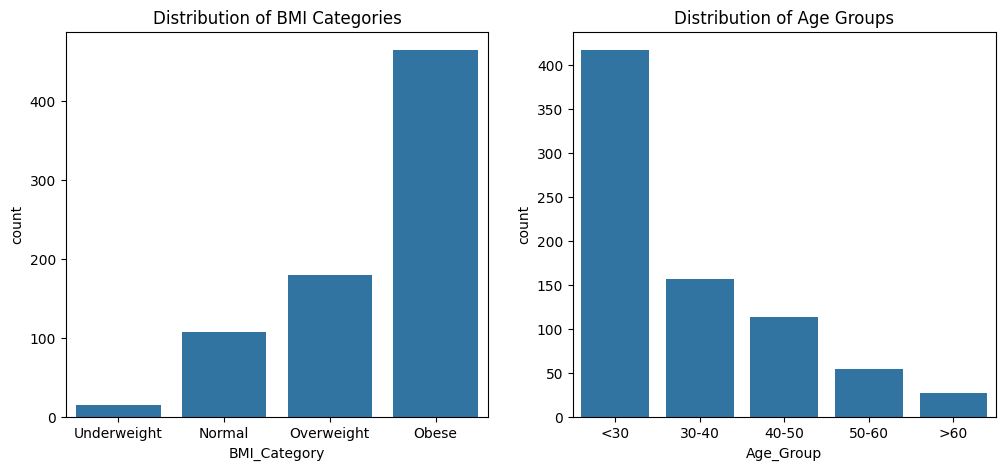

In [19]:


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=X_imputed, x="BMI_Category")
plt.title("Distribution of BMI Categories")

plt.subplot(1, 2, 2)
sns.countplot(data=X_imputed, x="Age_Group")
plt.title("Distribution of Age Groups")

plt.show()


## One-Hot Encoding of Categorical Features

In [20]:


categorical_features = ["BMI_Category", "Age_Group"]
encoder = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(), categorical_features)],
    remainder="passthrough",
)
X_encoded = encoder.fit_transform(X_imputed)


## Split the data

In [21]:

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)


## Scale the features

In [22]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Tune individual models

In [23]:

param_grid_rf = {"n_estimators": [100, 200, 300], "max_depth": [5, 10, 15]}
param_grid_etc = {"n_estimators": [100, 200, 300], "max_depth": [5, 10, 15]}
param_grid_xgb = {"n_estimators": [100, 200, 300], "max_depth": [3, 5, 7]}

rf_grid = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
etc_grid = GridSearchCV(ExtraTreesClassifier(), param_grid_etc, cv=5)
xgb_grid = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5)

print("Fitting Random Forest...")
rf_grid.fit(X_train_scaled, y_train)
print("Best parameters for Random Forest:", rf_grid.best_params_)

print("Fitting Extra Trees...")
etc_grid.fit(X_train_scaled, y_train)
print("Best parameters for Extra Trees:", etc_grid.best_params_)

print("Fitting XGBoost...")
xgb_grid.fit(X_train_scaled, y_train)
print("Best parameters for XGBoost:", xgb_grid.best_params_)


Fitting Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 300}
Fitting Extra Trees...
Best parameters for Extra Trees: {'max_depth': 10, 'n_estimators': 200}
Fitting XGBoost...
Best parameters for XGBoost: {'max_depth': 3, 'n_estimators': 100}


## Evaluate individual modelsd

In [24]:


rf_accuracy = accuracy_score(y_test, rf_grid.predict(X_test_scaled))
etc_accuracy = accuracy_score(y_test, etc_grid.predict(X_test_scaled))
xgb_accuracy = accuracy_score(y_test, xgb_grid.predict(X_test_scaled))

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Extra Trees Classifier Accuracy: {etc_accuracy:.2f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")


Random Forest Accuracy: 0.76
Extra Trees Classifier Accuracy: 0.74
XGBoost Accuracy: 0.74


## Ensemble model

In [25]:

voting_clf = VotingClassifier(
    estimators=[
        ("rf", rf_grid.best_estimator_),
        ("etc", etc_grid.best_estimator_),
        ("xgb", xgb_grid.best_estimator_),
    ],
    voting="soft",
)
voting_clf.fit(X_train_scaled, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=300)),
                             ('etc',
                              ExtraTreesClassifier(max_depth=10,
                                                   n_estimators=200)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

## Evaluate ensemble model

In [26]:

y_pred = voting_clf.predict(X_test_scaled)

ensemble_accuracy = accuracy_score(y_test, y_pred)
ensemble_precision = precision_score(y_test, y_pred)
ensemble_recall = recall_score(y_test, y_pred)
ensemble_f1 = f1_score(y_test, y_pred)
ensemble_mcc = matthews_corrcoef(y_test, y_pred)

print(f"Ensemble Accuracy: {ensemble_accuracy:.2f}")
print(f"Ensemble Precision: {ensemble_precision:.2f}")
print(f"Ensemble Recall: {ensemble_recall:.2f}")
print(f"Ensemble F1-Score: {ensemble_f1:.2f}")
print(f"Ensemble MCC: {ensemble_mcc:.2f}")


Ensemble Accuracy: 0.75
Ensemble Precision: 0.63
Ensemble Recall: 0.70
Ensemble F1-Score: 0.66
Ensemble MCC: 0.47


## Cross validate ensemble

In [27]:


X_scaled = scaler.fit_transform(X_encoded)
cv_scores = cross_val_score(voting_clf, X_scaled, y, cv=5, scoring="accuracy")
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Accuracy: 0.77


## Save model

In [28]:


joblib.dump(voting_clf, "diabetes_ensemble_model.joblib")
print("Model saved as 'diabetes_ensemble_model.joblib'")


Model saved as 'diabetes_ensemble_model.joblib'


## Visualize model performance

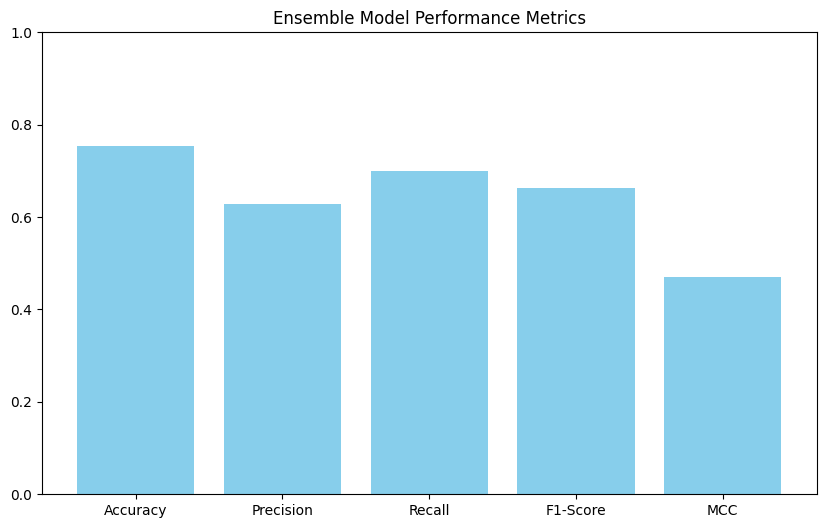

In [29]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']
values = [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1, ensemble_mcc]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title("Ensemble Model Performance Metrics")
plt.show()